# Imports en inlezen van data

In [153]:
import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
import seaborn as sns                               # Advanced data visualisation

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [154]:
df = pd.read_csv('weblogs.csv')

In [155]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = numeric_columns.drop('ROBOT')

# Analyse

In [156]:
df.columns

Index(['ID', 'NUMBER_OF_REQUESTS', 'TOTAL_DURATION', 'AVERAGE_TIME',
       'STANDARD_DEVIATION', 'REPEATED_REQUESTS', 'HTTP_RESPONSE_2XX',
       'HTTP_RESPONSE_3XX', 'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX',
       'GET_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'OTHER_METHOD', 'NIGHT',
       'UNASSIGNED', 'IMAGES', 'TOTAL_HTML', 'HTML_TO_IMAGE', 'HTML_TO_CSS',
       'HTML_TO_JS', 'WIDTH', 'DEPTH', 'STD_DEPTH', 'CONSECUTIVE', 'DATA',
       'PPI', 'SF_REFERRER', 'SF_FILETYPE', 'MAX_BARRAGE', 'PENALTY', 'ROBOT'],
      dtype='object')

In [157]:
corr_matrix = df.corr()

C:\Users\Dylan\AppData\Local\Temp\ipykernel_10236\3147368345.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


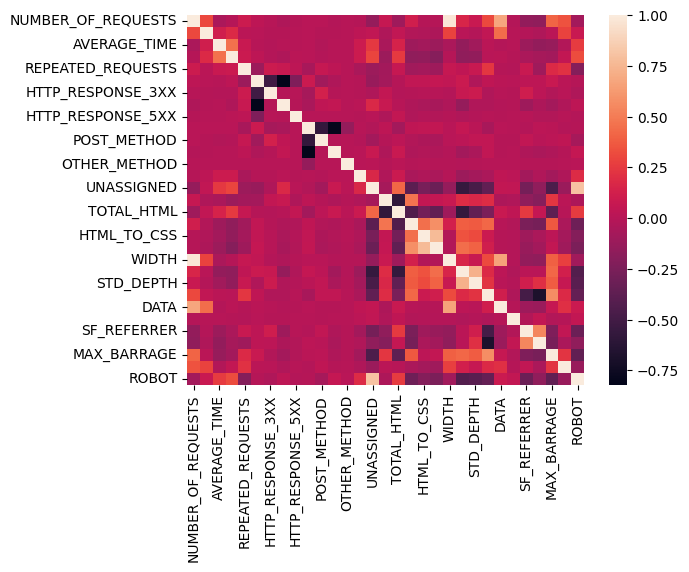

In [158]:
sn.heatmap(corr_matrix)
plt.show()

In [159]:
df['ROBOT'].value_counts()

0    53858
1    13494
Name: ROBOT, dtype: int64

# Data cleaning

Data is hevig geskewed. 50000 rijen zijn geen robot en 10000 zijn wel een robot.
Dit aanpassen.

In [160]:
""""""
robots = df[df['ROBOT'] == 1]

""""""
non_robots = df[df['ROBOT'] == 0]
non_robots = non_robots.sample(n=len(robots))

In [161]:
len(robots), len(non_robots)

(13494, 13494)

In [166]:
df.head()

,ID,NUMBER_OF_REQUESTS,TOTAL_DURATION,AVERAGE_TIME,STANDARD_DEVIATION,REPEATED_REQUESTS,HTTP_RESPONSE_2XX,HTTP_RESPONSE_3XX,HTTP_RESPONSE_4XX,HTTP_RESPONSE_5XX,...,DEPTH,STD_DEPTH,CONSECUTIVE,DATA,PPI,SF_REFERRER,SF_FILETYPE,MAX_BARRAGE,PENALTY,ROBOT
3,E7SowGoBCue8G08ECmHa,28,11,0.407407,1.097447,0.000000,1.0,0.0,0.0,0.0,...,3.0,0.000000,0.821429,45984.0,13.321429,0.037037,0.148148,5,0,0
5,FrSowGoBCue8G08ECmHa,11,96,9.600000,26.161804,0.000000,1.0,0.0,0.0,0.0,...,3.0,0.000000,0.545455,33250.0,13.727273,0.200000,0.400000,6,0,0
6,F7SowGoBCue8G08ECmHa,98,36,0.371134,1.795295,0.000000,1.0,0.0,0.0,0.0,...,6.0,1.281412,0.551020,504607.0,10.908163,0.113402,0.309278,30,0,0
8,HbSowGoBCue8G08ECmHa,186,477,2.578378,7.437347,0.032258,1.0,0.0,0.0,0.0,...,6.0,0.252624,0.645161,413016.0,12.833333,0.172973,0.329730,32,4,0
9,HrSowGoBCue8G08ECmHa,11,20,2.000000,4.427189,0.090909,1.0,0.0,0.0,0.0,...,6.0,1.489356,0.363636,27369.0,10.272727,0.200000,0.600000,3,0,0


In [162]:
for key in numeric_columns:
    m = df[key].mean()
    s = df[key].std()
    
    outlier_filter = (df[key] - m).abs() <= 3*s
    df = df[outlier_filter]

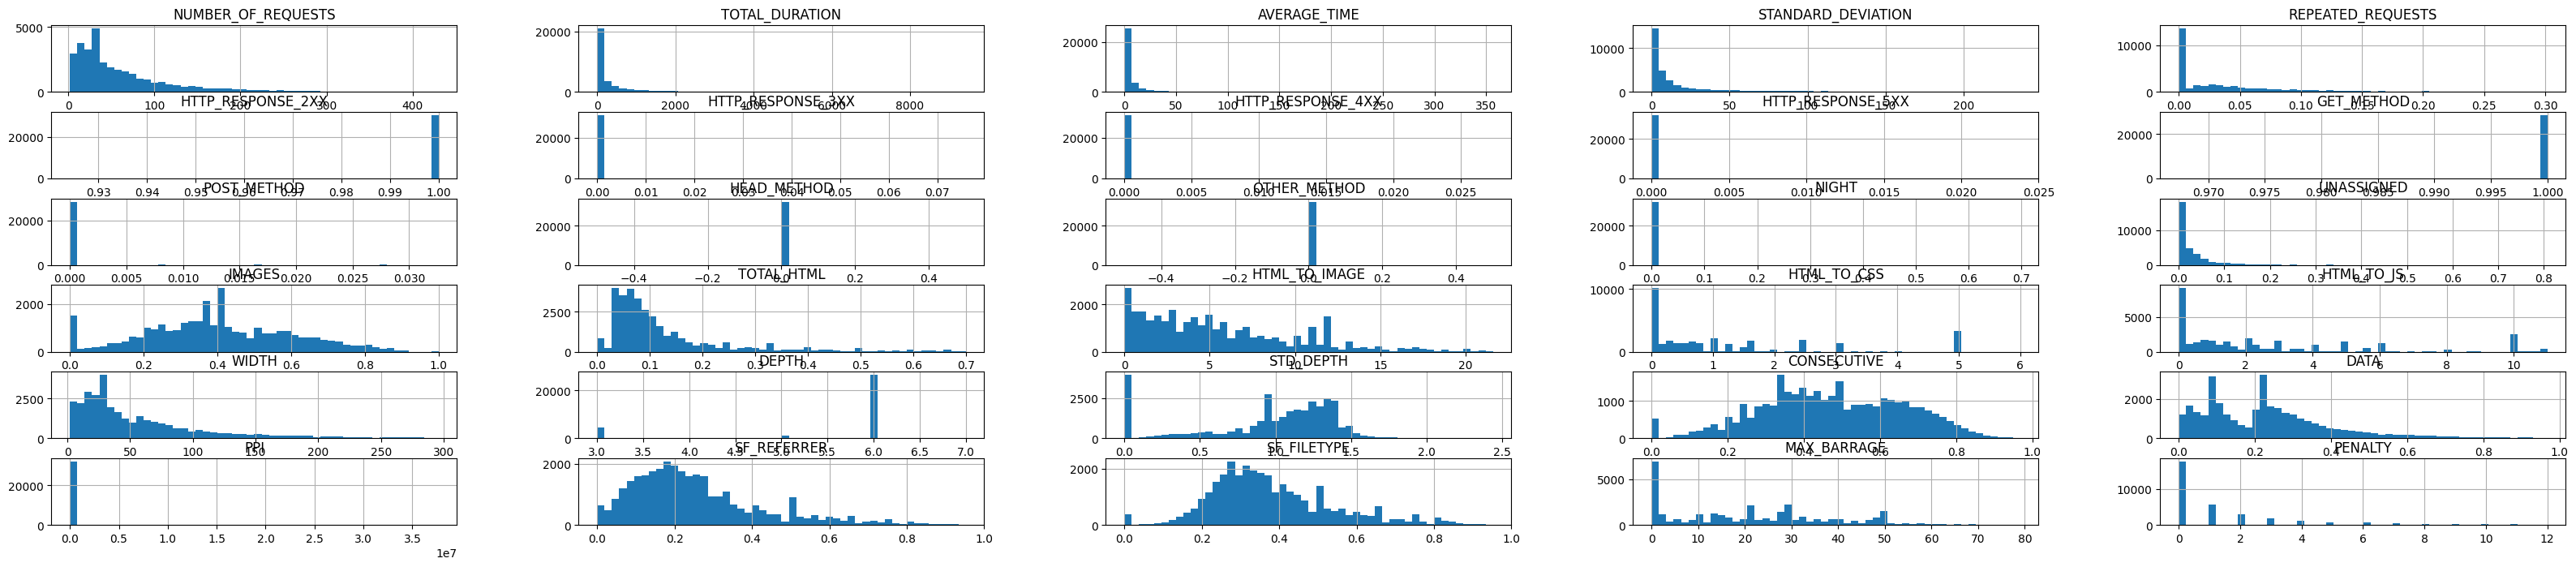

In [163]:
df[numeric_columns].hist(bins=50, figsize=(40,8))
plt.show()

In [165]:
df['ROBOT'].value_counts()

0    32043
1      165
Name: ROBOT, dtype: int64

# Classificatiemodel

In [113]:
X = df.drop(['ID', 'UNASSIGNED', 'ROBOT'], axis=1)
y = df['ROBOT']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

StandardScaler moet worden gebruikt als de gegevens normaal verdeeld zijn en MinMaxScaler als de gegevens naar een specifiek bereik moet worden geschaald.

In [115]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [116]:
col_transform = ColumnTransformer(transformers=[
    ('standard_scaler', StandardScaler(), numeric_columns)
    ])

In [117]:
# Random Forest
param_grid = { 
    'n_estimators': [100, 200, 400, 600],
    'max_leaf_nodes': [2, 4, 6, 10, 14, 16, 18],
    'max_depth' : [2, 4, 6, 8, 10]
}

grid_svc_rfc = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, scoring='accuracy', cv=3)

pipeline = Pipeline([
    ('prep',col_transform),
    ('grid_svc', grid_svc_rfc)
])

pipeline.fit(X_train, y_train)

print(f"best estimator = {grid_svc_rfc.best_estimator_}")
print(f"best score = {grid_svc_rfc.best_score_}")

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'accuracy --> {acc}')

best estimator = RandomForestClassifier(max_depth=2, max_leaf_nodes=2, random_state=42)
best score = 1.0
accuracy --> 1.0


In [118]:
# SVM
from sklearn.svm import SVR
svr_params = {'epsilon': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], "kernel": ["rbf", "poly", "sigmoid", "linear"], "degree": [1, 2, 3]}

grid_svc_svm = GridSearchCV(SVR(), svr_params, scoring='neg_mean_absolute_error', cv=3)
pipeline = Pipeline([('prep',col_transform), ('grid_svc', grid_svc_svm)])
pipeline.fit(X_train, y_train)

# best estimator
print(f"best estimator = {grid_svc_svm.best_estimator_}")
# best score
print(f"best score = {grid_svc_svm.best_score_}")

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'accuracy --> {acc}')

best estimator = SVR(degree=1)
best score = 0.0
accuracy --> 1.0


In [119]:
# Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

grid_clf_lr = GridSearchCV(LogisticRegression(multi_class="multinomial"), param_grid, scoring='accuracy', cv=3)

pipeline.fit(X_train, y_train)

print(f"best estimator = {grid_clf_lr.best_estimator_}")
print(f"best score = {grid_clf_lr.best_score_}")

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'accuracy --> {acc}')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': (0.05,0.1, 0.2, 0.3,0.4),
    'min_samples_leaf': (0.05,0.1,0.2, 0.3,0.4)
}

grid_clf_dc = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, scoring='accuracy', cv=3)

grid_clf_dc.fit(X_train,y_train)

print(f"best estimator = {grid_clf_dc.best_estimator_}")
print(f"best score = {grid_clf_dc.best_score_}")

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'accuracy --> {acc}')

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('log_clf', grid_clf_lr.best_estimator_), ('rnd_clf', grid_svc_rfc.best_estimator_), ('svm_clf', grid_svc_svm.best_estimator_), ('dc_clf', grid_clf_dc.best_estimator_)],
    voting='soft')

all_clf = [
  ('log_clf', grid_clf_lr.best_estimator_), ('rnd_clf', grid_svc_rfc.best_estimator_),
  ('svm_clf', grid_svc_svm.best_estimator_), ('dc_clf', grid_clf_dc.best_estimator_), ('vot_clf', voting_clf)
]

for clf_tuple in all_clf:
  pipeline = Pipeline([
    ('prep',col_transform),
    (clf_tuple[0], clf_tuple[1])
])

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(f"{clf_tuple[0]} accuracy_score = {accuracy_score(y_test, y_pred)}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

## Optimaal model kiezen

## Confusion matrix